In [32]:
# Initial setup
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

df_full = pd.read_json('yelp_academic_dataset_business.json', lines = True)
tip = pd.read_json('yelp_academic_dataset_tip.json', lines = True)

## 1. Data Preprocessing
In this section, we will transform the Yelp dataset and produce the format required for data mining and modeling through the following steps:

- Filter to U.S. restaurants that were opened in 2016
- Flatten attributes and categories
- Transform categorical variables into dummy variables
- Handling missing values

In [33]:
# Filter to U.S. restaurants that were opened in 2016
# 1) Filter to U.S. businesses
zip_crosswalk = pd.read_csv('zip_crosswalk.csv')
# Transform digit-only postal code to int
digit_only = df_full['postal_code'].map(lambda x: True if all(i.isdigit() for i in x) else False)
df_full = df_full[(digit_only) & (df_full['postal_code'] != '')]
df_full['postal_code_int'] = [int(x) for x in df_full['postal_code']]
# Join crosswalk by zip and state
df = pd.merge(df_full, zip_crosswalk[['ZIP', 'STATE']], 
              left_on = ['postal_code_int', 'state'],
              right_on = ['ZIP', 'STATE'])

# 2) Filter to restaurants
df = df[df['categories'].str.contains('Restaurants|Food', na = False)]

# 3) Filter to restaurants that were opened in 2016
start = '2015-01-01'
end = '2016-12-31'
tip = tip.groupby('business_id')['date'].min().reset_index()
tip = tip[(tip['date'] >= start) & (tip['date'] <= end)]
df = pd.merge(tip, df, on = 'business_id')

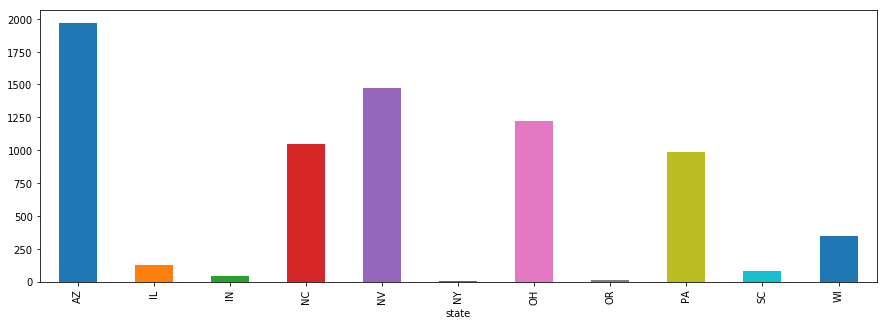

In [34]:
# Check geological distribution
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
df.groupby('state')['business_id'].count().plot(kind = 'bar')
plt.show()

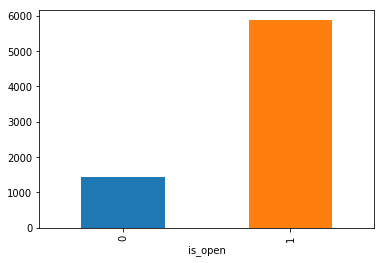

In [35]:
# Check restaurant closure
df.groupby('is_open')['business_id'].count().plot(kind = 'bar')
plt.show()

In [36]:
# Flatten attributes and categories

In [37]:
# Transform categorical variables into dummy

In [38]:
# Handling missing values

## 2. External Data
In this section, we will integrate the following external data sources to the Yelp dataset:
- Zillow property price data
- Demographic data by zip code

In [39]:
# Zillow

In [40]:
from uszipcode import SearchEngine
zipcodes = df['postal_code'].unique()
keys = ['zipcode', 'housing_units', 'land_area_in_sqmi', 'median_home_value', 'median_household_income', \
        'occupied_housing_units', 'population', 'population_density', 'annual_individual_earnings', \
        'educational_attainment_for_population_25_and_over', 'employment_status', 'families_vs_singles', \
        'households_with_kids', 'housing_occupancy', 'means_of_transportation_to_work_for_workers_16_and_over', \
        'population_by_age', 'population_by_gender', 'population_by_race', 'travel_time_to_work_in_minutes']
lst = []
for zipcode in zipcodes:
    search = SearchEngine(simple_zipcode=False) 
    item = search.by_zipcode(zipcode)
    newDict  = item.to_dict()
    lst.append([newDict.get(key) for key in keys])
keys[0] = 'postal_code'
df_demograph = pd.DataFrame(lst, columns=keys)
df = pd.merge(df, df_demograph, on='postal_code', how='inner')

## 3. Feature Engineering
In this section, we will perform feature engineering to extract the following attributes:
- Restaurant density and competition level in the neighborhood
- Whether a given restaurant belong to a local/national chain

In [41]:
# Restaurant density

In [42]:
# Chain